<a href="https://colab.research.google.com/github/leonardoub/cmepda/blob/master/brats_classification_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [0]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
dataset_path = '/gdrive/My Drive/BRATS/data_without_NAN_with_histologies.csv'

In [0]:
df_data = pd.read_csv(dataset_path)

In [0]:
df_data

,Unnamed: 0,ID,Date,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,VOLUME_NET_over_TC,VOLUME_ED_over_TC,VOLUME_ET_OVER_WT,VOLUME_NET_OVER_WT,VOLUME_ED_OVER_WT,VOLUME_TC_OVER_WT,VOLUME_ET_OVER_BRAIN,VOLUME_NET_OVER_BRAIN,VOLUME_ED_over_BRAIN,VOLUME_TC_over_BRAIN,VOLUME_WT_OVER_BRAIN,DIST_Vent_TC,DIST_Vent_ED,INTENSITY_Mean_ET_T1Gd,INTENSITY_STD_ET_T1Gd,INTENSITY_Mean_ET_T1,INTENSITY_STD_ET_T1,INTENSITY_Mean_ET_T2,INTENSITY_STD_ET_T2,INTENSITY_Mean_ET_FLAIR,INTENSITY_STD_ET_FLAIR,INTENSITY_Mean_NET_T1Gd,INTENSITY_STD_NET_T1Gd,INTENSITY_Mean_NET_T1,INTENSITY_STD_NET_T1,INTENSITY_Mean_NET_T2,INTENSITY_STD_NET_T2,...,TEXTURE_NGTDM_ED_T1_Busyness,TEXTURE_NGTDM_ED_T1_Complexity,TEXTURE_NGTDM_ED_T1_Strength,TEXTURE_NGTDM_ED_T2_Coarseness,TEXTURE_NGTDM_ED_T2_Contrast,TEXTURE_NGTDM_ED_T2_Busyness,TEXTURE_NGTDM_ED_T2_Complexity,TEXTURE_NGTDM_ED_T2_Strength,TEXTURE_NGTDM_ED_FLAIR_Coarseness,TEXTURE_NGTDM_ED_FLAIR_Contrast,TEXTURE_NGTDM_ED_FLAIR_Busyness,TEXTURE_NGTDM_ED_FLAIR_Complexity,TEXTURE_NGTDM_ED_FLAIR_Strength,TEXTURE_NGTDM_NET_T1Gd_Coarseness,TEXTURE_NGTDM_NET_T1Gd_Contrast,TEXTURE_NGTDM_NET_T1Gd_Busyness,TEXTURE_NGTDM_NET_T1Gd_Complexity,TEXTURE_NGTDM_NET_T1Gd_Strength,TEXTURE_NGTDM_NET_T1_Coarseness,TEXTURE_NGTDM_NET_T1_Contrast,TEXTURE_NGTDM_NET_T1_Busyness,TEXTURE_NGTDM_NET_T1_Complexity,TEXTURE_NGTDM_NET_T1_Strength,TEXTURE_NGTDM_NET_T2_Coarseness,TEXTURE_NGTDM_NET_T2_Contrast,TEXTURE_NGTDM_NET_T2_Busyness,TEXTURE_NGTDM_NET_T2_Complexity,TEXTURE_NGTDM_NET_T2_Strength,TEXTURE_NGTDM_NET_FLAIR_Coarseness,TEXTURE_NGTDM_NET_FLAIR_Contrast,TEXTURE_NGTDM_NET_FLAIR_Busyness,TEXTURE_NGTDM_NET_FLAIR_Complexity,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1,Histology
0,0,TCGA-02-0006,1996.08.23,1662,384,36268,2046,38314,1469432,4.328125,0.045826,0.010588,0.812320,0.187680,17.726300,0.043378,0.010022,0.946599,0.053401,0.001131,0.000261,0.024682,0.001392,0.026074,31.5903,2.7735,149.7977,10.4671,194.1422,15.1037,154.9225,43.4709,220.5894,30.2917,137.8881,6.3820,183.6933,14.8846,161.1005,35.8591,...,0.86315,1479.9762,1.10870,0.000605,0.40937,1.47070,2992.2698,0.71642,0.000690,0.28977,1.8815,1872.0528,0.75986,0.026040,0.37869,0.060929,1675.0041,14.11380,0.044156,0.41942,0.026740,2536.7559,43.31290,0.036634,0.50304,0.024264,3593.3279,43.67590,0.057204,0.33980,0.021897,2203.2034,61.32930,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.00000,GBM
1,1,TCGA-02-0009,1997.06.14,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.500750,0.499250,1.805000,0.178522,0.177990,0.643489,0.356511,0.003366,0.003356,0.012135,0.006723,0.018857,9.2443,3.0207,165.4345,6.4047,201.2400,13.4733,113.1601,10.1373,210.1810,15.9543,152.6013,4.2360,188.0607,11.1316,116.8538,10.0992,...,0.40004,2378.9184,2.54730,0.000914,0.70926,0.78063,5719.2847,1.29980,0.000882,0.48919,1.8243,2954.8148,0.77199,0.002254,0.29324,1.223600,539.3057,0.53125,0.005712,0.20995,0.315580,967.7845,3.74440,0.003790,0.36163,0.271420,1996.1440,2.77050,0.004966,0.28715,0.189980,1440.4285,3.59990,3.31250,1.000000e-09,0.077618,0.122900,0.094336,91.47360,GBM
2,2,TCGA-02-0011,1998.02.01,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.061444,0.407290,0.592710,0.558400,0.261349,0.380334,0.358318,0.641682,0.023428,0.034094,0.032120,0.057521,0.089641,1.0000,1.0000,186.3385,17.6126,188.2019,23.5195,172.8969,32.7401,167.1395,34.1684,149.0643,12.9090,158.4197,15.2632,197.4966,27.1781,...,1.51780,1750.3404,0.56482,0.000382,0.59301,1.81810,4990.3388,0.54747,0.000345,0.59184,2.4243,4703.9458,0.41937,0.000403,0.37863,1.957500,2509.3979,0.42842,0.000768,0.19849,1.395800,1322.6082,0.74730,0.000634,0.31856,1.144300,2517.8629,0.84294,0.000794,0.17961,1.068800,1147.5177,0.80480,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.42900,GBM
3,3,TCGA-02-0027,1999.03.28,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,0.614890,0.385110,1.730200,0.2252

In [0]:
df_data.columns

Index(['Unnamed: 0', 'ID', 'Date', 'VOLUME_ET', 'VOLUME_NET', 'VOLUME_ED',
       'VOLUME_TC', 'VOLUME_WT', 'VOLUME_BRAIN', 'VOLUME_ET_OVER_NET',
       ...
       'TEXTURE_NGTDM_NET_FLAIR_Busyness',
       'TEXTURE_NGTDM_NET_FLAIR_Complexity',
       'TEXTURE_NGTDM_NET_FLAIR_Strength', 'TGM_p1', 'TGM_dw', 'TGM_Cog_X_1',
       'TGM_Cog_Y_1', 'TGM_Cog_Z_1', 'TGM_T_1', 'Histology'],
      dtype='object', length=708)

In [0]:
data = df_data.drop(['Histology', 'Unnamed: 0', 'ID', 'Date'], axis=1)

In [0]:
labels = df_data.Histology

#NO K-FOLD

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=1)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=0.2, stratify=y_train_big, random_state=2)                                                         

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

#PCA

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(train_data_stand)
train_data_stand_pca = pca.transform(train_data_stand)
val_data_stand_pca = pca.transform(val_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)
train_data_stand_pca.shape

(92, 40)

##Z-score dopo PCA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_pca = scaler_2.fit_transform(train_data_stand_pca)
val_data_stand_pca = scaler_2.transform(val_data_stand_pca)
test_data_stand_pca = scaler_2.transform(test_data_stand_pca)

##Vettorizzare i label

In [0]:
word_index={'GBM':0, 'LGG':1}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(30, activation='relu', input_shape=(9,), kernel_regularizer=regularizers.l2(l=0.001)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
  #model.add(layers.Dropout(0.1))

  model.add(layers.Dense(2, activation='softmax'))

  sgd = SGD(lr=0.01, momentum=0.9)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [0]:

one_hot_val_labels.shape

(24, 2)

In [0]:
num_epochs = 1000

model = build_model()
history = model.fit(train_data_stand_pca, one_hot_train_labels, validation_data=(val_data_stand_pca, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=10)
  

acc_history = history.history['acc']
loss_history = history.history['loss']
acc_val_history = history.history['val_acc']
loss_val_history = history.history['val_loss']


RuntimeError: ignored

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

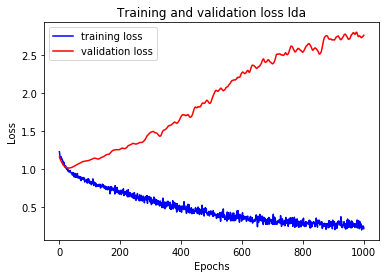

In [0]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

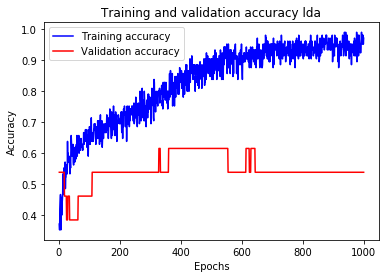

In [0]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [0]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=105, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/1000
105/105 [==============================] - 3s 25ms/step - loss: 1.3937 - acc: 0.1905
Epoch 2/1000
105/105 [==============================] - 0s 53us/step - loss: 1.4110 - acc: 0.1810
Epoch 3/1000
105/105 [==============================] - 0s 29us/step - loss: 1.3383 - acc: 0.2571
Epoch 4/1000
105/105 [==============================] - 0s 36us/step - loss: 1.3043 - acc: 0.2381
Epoch 5/1000
105/105 [==============================] - 0s 40us/step - loss: 1.3153 - acc: 0.2286
Epoch 6/1000
105/105 [==============================] - 0s 38us/step - loss: 1.3610 - acc: 0.2381
Epoch 7/1000
105/105 [==============================] - 0s 35us/step - loss: 1.2880 - acc: 0.1810
Epoch 8/1000
105/105 [==============================] - 0s 32us/step - loss: 1.3193 - acc: 0.2286
Epoch 9/1000
105/105 [==============================] - 0s 29us/step - loss: 1.2666 - acc: 0.2381
Epoch 10/1000
105/105 [==============================] - 0s 29us/step - loss: 1.2252 - acc: 0.2952
Epoch 11/1000
105/1

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
test_acc


0.4615384638309479

Si comporta molto bene in training e in validation ma si comporta male in test